<a href="https://colab.research.google.com/github/mokv/WaterPumpsML/blob/main/water_pumps_1701681005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import
Import training and testing data sets.

In [ ]:
import pandas as pd

train_set = pd.read_csv('https://ml.monov.eu/pumps/train_pumps.csv')
test_set = pd.read_csv('https://ml.monov.eu/pumps/test_pumps.csv')

We combine the two data sets so that we proccess the data as a whole. Later we'll split the data into two parts for training, validation and testing.

In [ ]:
whole_set = pd.concat([train_set, test_set])
whole_set.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,71382,0.0,Twesa,0,TWESA,32.880835,-3.592052e+00,Lyagiti Shuleni,0,Lake Victoria,Mwabaluhi,Shinyanga,17,3,Shinyanga Rural,Lyabukande,0,False,Parastatal,NaN,True,0,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,functional needs repair
1,67471,20.0,Government Of Tanzania,971,DWE,36.824159,-3.500453e+00,Kwa Tomasi Emanuel,0,Pangani,Marurani Kati,Arusha,2,2,Arusha Rural,Nduruma,150,True,VWC,Machumba estate pipe line,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional needs repair
2,22778,200.0,Mwaya Mn,262,Communit,36.906584,-7.835830e+00,Kwamakingi,0,Rufiji,Mlagayai,Morogoro,5,3,Kilombero,Mang'ula,200,True,WUA,Mangula,True,2009,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,functional needs repair
3,26356,500.0,Unicef/central,1737,DWE,34.697489,-9.110604e+00,Shuleni,0,Rufiji,Ngelele,Iringa,11,4,Njombe,Mdandu,350,True,WUA,wanging'ombe water supply s,True,1974,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,others
4,70935,0.0,Dwsp,0,DWE,0.000000,-2.000000e-08,Izinga,0,Lake Victoria,Mwakapalala,Shinyanga,17,1,Bariadi,Nkoma,0,True,WUG,NaN,False,0,swn 80,swn 80,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,functional needs repair


#Process Data
Now we define the columns that we're going to process and use later.

In [ ]:
num_cols = ['gps_height', 'longitude', 'latitude', 'population', 'construction_year', 'amount_tsh']
cat_cols = ['funder', 'installer', 'basin', 'subvillage', 'lga', 'region_code', 'payment', 'payment_type'
          , 'ward', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'waterpoint_type'
          , 'extraction_type_group', 'extraction_type_class', 'management', 'management_group'
          , 'water_quality', 'quality_group', 'quantity', 'source', 'quantity_group', 'source_type', 'source_class'
          , 'waterpoint_type_group']
out_cols = ['status_group']

## Convert categorical values to numeric
We convert categorical string values into numeric values so that we can do the math on them. This includes the output column as well.

In [ ]:
for cat in cat_cols:
  whole_set[cat] = whole_set[cat].astype('category').cat.codes.values

for out in out_cols:
  whole_set[out] = whole_set[out].astype('category').cat.codes.values

whole_set.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,71382,0.0,615,0,647,32.880835,-3.592052e+00,Lyagiti Shuleni,0,4,3887,Shinyanga,16,3,103,773,0,0,2,NaN,1,0,9,6,3,3,2,0,2,6,2,3,3,5,3,1,5,4,0
1,67471,20.0,175,971,156,36.824159,-3.500453e+00,Kwa Tomasi Emanuel,0,5,2890,Arusha,1,2,0,1316,150,1,6,Machumba estate pipe line,1,2009,3,1,0,7,4,4,5,6,2,2,2,8,6,0,1,1,0
2,22778,200.0,388,262,116,36.906584,-7.835830e+00,Kwamakingi,0,6,3446,Morogoro,4,3,35,878,200,1,7,Mangula,1,2009,3,1,0,7,4,3,1,6,2,2,2,6,4,1,1,1,0
3,26356,500.0,629,1737,156,34.697489,-9.110604e+00,Shuleni,0,6,4403,Iringa,10,4,91,988,350,1,7,wanging'ombe water supply s,1,1974,3,1,0,10,4,3,1,6,2,1,1,6,4,1,1,1,1
4,70935,0.0,137,0,156,0.000000,-2.000000e-08,Izinga,0,4,3944,Shinyanga,16,1,5,1371,0,1,8,NaN,0,0,14,11,1,11,4,5,3,6,2,2,2,7,5,0,5,4,0


## Remove useless columns
There are columns that don't need to convert them and they are unneeded since they don't bring any value to the model. For example, 'wpt_name', 'scheme_name' are only names that don't indicate anything related to the condition of the pipes. We'll remove everything that is not part of the selected columns. 

In [ ]:
used_columns = num_cols + cat_cols + out_cols
columns_to_remove = [col for col in whole_set.columns if col not in used_columns ]

print(columns_to_remove)

['id', 'wpt_name', 'num_private', 'region', 'district_code', 'scheme_name']


In [ ]:
whole_set = whole_set.drop(columns=columns_to_remove)
whole_set.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,0.0,615,0,647,32.880835,-3.592052e+00,4,3887,16,103,773,0,0,2,1,0,9,6,3,3,2,0,2,6,2,3,3,5,3,1,5,4,0
1,20.0,175,971,156,36.824159,-3.500453e+00,5,2890,1,0,1316,150,1,6,1,2009,3,1,0,7,4,4,5,6,2,2,2,8,6,0,1,1,0
2,200.0,388,262,116,36.906584,-7.835830e+00,6,3446,4,35,878,200,1,7,1,2009,3,1,0,7,4,3,1,6,2,2,2,6,4,1,1,1,0
3,500.0,629,1737,156,34.697489,-9.110604e+00,6,4403,10,91,988,350,1,7,1,1974,3,1,0,10,4,3,1,6,2,1,1,6,4,1,1,1,1
4,0.0,137,0,156,0.000000,-2.000000e-08,4,3944,16,5,1371,0,1,8,0,0,14,11,1,11,4,5,3,6,2,2,2,7,5,0,5,4,0


## Normalize data
Next step is to "normalize" our data. Our normalization would mean to convert all of the values to be between 0 and 1. This will ease the model's work.

In [ ]:
def normalize(x):
  # min-max normalization to 0-1 range
  x_min = x.min()
  x_max = x.max()
  return (x - x_min) / (x_max - x_min)

In [ ]:
train_cols = cat_cols + num_cols

for col in train_cols:
  whole_set[col] = normalize(whole_set[col])

whole_set.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,0.000000,0.886331,0.020163,0.830769,0.815861,0.691655,0.500,0.688629,0.64,0.837398,0.444764,0.000000,0.5,0.272727,1.0,0.000000,0.5625,0.500000,0.500000,0.272727,0.5,0.000000,0.333333,0.857143,0.4,0.75,0.75,0.555556,0.500000,0.5,1.0,1.00,0
1,0.000167,0.253237,0.363636,0.201282,0.913706,0.699518,0.625,0.512044,0.04,0.000000,0.757192,0.009804,1.0,0.636364,1.0,0.998013,0.1875,0.083333,0.000000,0.636364,1.0,0.666667,0.833333,0.857143,0.4,0.50,0.50,0.888889,1.000000,0.0,0.2,0.25,0
2,0.001667,0.559712,0.112840,0.150000,0.915751,0.327364,0.750,0.610521,0.16,0.284553,0.505178,0.013072,1.0,0.727273,1.0,0.998013,0.1875,0.083333,0.000000,0.636364,1.0,0.500000,0.166667,0.857143,0.4,0.50,0.50,0.666667,0.666667,0.5,0.2,0.25,0
3,0.004167,0.906475,0.634595,0.201282,0.860937,0.217936,0.750,0.780021,0.40,0.739837,0.568470,0.022876,1.0,0.727273,1.0,0.980626,0.1875,0.083333,0.000000,0.909091,1.0,0.500000,0.166667,0.857143,0.4,0.25,0.25,0.666667,0.666667,0.5,0.2,0.25,1
4,0.000000,0.198561,0.020163,0.201282,0.000000,1.000000,0.500,0.698725,0.64,0.040650,0.788838,0.000000,1.0,0.818182,0.5,0.000000,0.8750,0.916667,0.166667,1.000000,1.0,0.833333,0.500000,0.857143,0.4,0.50,0.50,0.777778,0.833333,0.0,1.0,1.00,0


## Fill empty values with average
We will fill all of the numerical values that have 0s with the mean of the set.

In [ ]:
for col in num_cols:
  whole_set[col] = whole_set[col].replace(0, whole_set[col].mean())
  
whole_set.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,0.002620,0.886331,0.020163,0.830769,0.815861,0.691655,0.500,0.688629,0.64,0.837398,0.444764,0.011756,0.5,0.272727,1.0,0.629881,0.5625,0.500000,0.500000,0.272727,0.5,0.000000,0.333333,0.857143,0.4,0.75,0.75,0.555556,0.500000,0.5,1.0,1.00,0
1,0.000167,0.253237,0.363636,0.201282,0.913706,0.699518,0.625,0.512044,0.04,0.000000,0.757192,0.009804,1.0,0.636364,1.0,0.998013,0.1875,0.083333,0.000000,0.636364,1.0,0.666667,0.833333,0.857143,0.4,0.50,0.50,0.888889,1.000000,0.0,0.2,0.25,0
2,0.001667,0.559712,0.112840,0.150000,0.915751,0.327364,0.750,0.610521,0.16,0.284553,0.505178,0.013072,1.0,0.727273,1.0,0.998013,0.1875,0.083333,0.000000,0.636364,1.0,0.500000,0.166667,0.857143,0.4,0.50,0.50,0.666667,0.666667,0.5,0.2,0.25,0
3,0.004167,0.906475,0.634595,0.201282,0.860937,0.217936,0.750,0.780021,0.40,0.739837,0.568470,0.022876,1.0,0.727273,1.0,0.980626,0.1875,0.083333,0.000000,0.909091,1.0,0.500000,0.166667,0.857143,0.4,0.25,0.25,0.666667,0.666667,0.5,0.2,0.25,1
4,0.002620,0.198561,0.020163,0.201282,0.817945,1.000000,0.500,0.698725,0.64,0.040650,0.788838,0.011756,1.0,0.818182,0.5,0.629881,0.8750,0.916667,0.166667,1.000000,1.0,0.833333,0.500000,0.857143,0.4,0.50,0.50,0.777778,0.833333,0.0,1.0,1.00,0


#Prepare data
Our data has been processed but now we need to prepare it in the appropriate formats in order to work for our model.

## Split data into needed chunks for Training, Validation and Testing.

We'll split all we got into three data sets. First one is to train the model. Second one will be to validate our accuracy. This data set will be extracted from the training set. Third one will be the testing set to which we'll challenge our model

In [ ]:
print(train_set.shape)
print(test_set.shape)
print(whole_set.shape)

(6716, 39)
(2500, 38)
(9216, 33)


In [ ]:
train_set_length = int(train_set.shape[0] * 0.8)
validation_set_length = int(train_set.shape[0] * 0.2)

# Add remaining value of precision conversion to the train set
remaining_length = train_set.shape[0] - (train_set_length + validation_set_length)
train_set_length += remaining_length

test_set_length = test_set.shape[0]

print(train_set_length)
print(validation_set_length)
print(test_set_length)

5373
1343
2500


In [ ]:
splitted_train_set = whole_set[:train_set_length]
splitted_validation_set = whole_set[train_set_length:train_set_length + validation_set_length]
splitted_test_set = whole_set.tail(test_set_length)

print(splitted_train_set.shape)
print(splitted_validation_set.shape)
print(splitted_test_set.shape)

(5373, 33)
(1343, 33)
(2500, 33)


## Create tensors to use pytorch

We need the data sets in tensor objects in order to fit in our model.

In [ ]:
import torch
import torch.nn as nn

tensor_train_set_features = torch.tensor(splitted_train_set[num_cols + cat_cols].values, dtype=torch.float)
tensor_train_set_labels = torch.tensor(splitted_train_set[out_cols].values, dtype=torch.float)
tensor_validation_set_features = torch.tensor(splitted_validation_set[num_cols + cat_cols].values, dtype=torch.float)
tensor_validation_set_labels = torch.tensor(splitted_validation_set[out_cols].values, dtype=torch.float)
tensor_test_set_features = torch.tensor(splitted_test_set[num_cols + cat_cols].values, dtype=torch.float)

# Create Deep learning Model

## Define our Network Model

We'll be using two layers and we'll turn the output between 0 and 1 using sigmoid function. This will tell us how likely is our pipe to need repair. For example, if the output is 0.7 that means that our model is 70% confident that this pipe needs a repair.

In [ ]:
class Net(nn.Module):
  def __init__(self, input_length, output_length, neurons):
    super().__init__()
    self.layer_1 = nn.Linear(input_length, neurons)
    self.layer_2 = nn.Linear(neurons, neurons)
    self.output = nn.Linear(neurons, output_length)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_set):
    x = self.layer_1(input_set)
    x = self.layer_2(x)
    x = self.output(x)
    x = self.sigmoid(x)
    return x

Selecting loss function and optimizer. For the loss function, we use Binary Cross-Entropy (BCE), which is known as the binary logarithmic loss function. This is commonly used for logistic regression tasks since we are predicting a binary value as output.

In [ ]:
loss_func = nn.BCELoss()

## Define training function
This function will do all of the necessary work to train our model. We're using the standard Adam optimizer.

In [ ]:
def train(net, train_data, train_labels, num_epochs, learning_rate, weight_decay, batch_size):
  loss_list = []
  train_tensor = torch.utils.data.TensorDataset(torch.Tensor(train_data), torch.Tensor(train_labels))
  train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

  for epoch in range(num_epochs):
    loss_items = []
    for train_data, label_data in train_loader:
      optimizer.zero_grad()
      output = net(train_data)
      loss = loss_func(output, label_data)
      loss.backward()
      optimizer.step()
      loss_item = loss.item()
      loss_items.append(loss_item)

    if(epoch % 10 == 0):
      print('epoch {}, loss{}'.format(epoch, loss_items))

    loss_list.append(loss_items)
  return loss_list

### Create network model

In [ ]:
net = Net(input_length=tensor_train_set_features.shape[1],
          output_length = 1, 
          neurons = 64)

## Train the model
We'll train the created model using our predefined function.

In [ ]:
num_epochs = 180

loss_list = train(net = net, 
                  train_data = tensor_train_set_features,
                  train_labels = tensor_train_set_labels,
                  num_epochs = num_epochs,
                  learning_rate = 0.0001,
                  weight_decay = 0,
                  batch_size = 3000)

epoch 0, loss[0.707190752029419, 0.7085080742835999]
epoch 10, loss[0.6933349370956421, 0.6902385354042053]
epoch 20, loss[0.6891084909439087, 0.6877664923667908]
epoch 30, loss[0.6858841776847839, 0.6868568062782288]
epoch 40, loss[0.6843290328979492, 0.6834620833396912]
epoch 50, loss[0.681273341178894, 0.6815304160118103]
epoch 60, loss[0.6787890195846558, 0.6783320903778076]
epoch 70, loss[0.6753145456314087, 0.6758344173431396]
epoch 80, loss[0.6728010773658752, 0.6715788841247559]
epoch 90, loss[0.6703540682792664, 0.6667683124542236]
epoch 100, loss[0.6626851558685303, 0.668294370174408]
epoch 110, loss[0.6600751280784607, 0.6633554100990295]
epoch 120, loss[0.6599143743515015, 0.6555271148681641]
epoch 130, loss[0.6572100520133972, 0.6514119505882263]
epoch 140, loss[0.65547776222229, 0.6468012928962708]
epoch 150, loss[0.651934802532196, 0.6452037692070007]
epoch 160, loss[0.6465805768966675, 0.6467110514640808]
epoch 170, loss[0.6444458961486816, 0.6448232531547546]


### Loss visualization

Visualizing loss function helps us determine whether we need more/less epochs to train and helps us spot if we're overfitting our model.

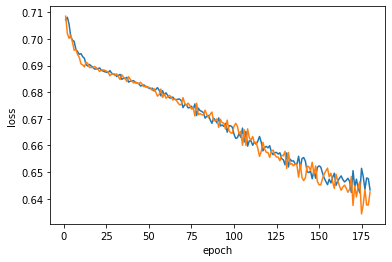

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Convert prediction to final result

We'll use our validation set to determine how well our model did. However, right now our values are varying between 0 and 1 but we need them to be either 0 or 1. So we'll convert our values to be binary.

In [ ]:
needs_repair_treshold = 0.5

prediction = net(tensor_validation_set_features)
prediction = (prediction>needs_repair_treshold).float()

print(prediction)
print(tensor_validation_set_labels)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]])
tensor([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [1.],
        [0.]])


### Find model accuracy

In [ ]:
correct = 0
total = 0

for index, pred in enumerate(prediction):
  if pred == tensor_validation_set_labels[index]:
    correct += 1
  total += 1

print('Accuracy: ', round(correct / total, 3))

Accuracy:  0.634


# Work on test data

In [ ]:
test_prediction = net(tensor_test_set_features)
test_prediction = (test_prediction > needs_repair_treshold).float()

test_set_result = test_set
test_set_result[out_cols] = test_prediction
test_set_result = test_set_result[['id', out_cols[0]]]
test_set_result.head()

,id,status_group
0,51075,1.0
1,69689,0.0
2,39970,0.0
3,15021,0.0
4,15400,1.0


# Download CSV Result

In [ ]:
from google.colab import files
 
test_set_result.to_csv('result.csv')
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>